# Sensor Fusion

The term "Sensor Fusion" reflects the combination of information from various sensors that typically operates independently and provide their measurements with different sampling rates and in different points in time. In addition, these sensors are often placed at different locations on the platform itself thus introducing lever arms relative to a common point of reference.

![tracks](fig/tracks.jpg)

Let's start with a simple example with our Trolley on rails combining two sensors, i.e. laser scanner and odometry. Eventhough these two sensors are very different in their construction, both can provide information related to position and velocity.

```{figure} fig/laser_speed.png
:name: laser_speed

Laser Scanner and Speedometer
```

## Example 7.1
From our well known Trolley on rails example, we give the Trolley a slight push and let it roll down the rails with som random noise related to its velocity through a *PV-model*.

The dynamic model will then look like this.

$$
x=
\begin{bmatrix}
  x_1\\
  x_2\\
\end{bmatrix}
$$

$$
\begin{bmatrix}
  \dot{x_1}\\
  \dot{x_2}\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &1\\
  0 &0\\
\end{bmatrix}
\begin{bmatrix}
  x_1\\
  x_2\\
\end{bmatrix}
+
\begin{bmatrix}
  0\\
  \sqrt{q_v}\\
\end{bmatrix}
u
$$

where $x_1$ denotes the position and $x_2$ denotes the velocity.

Note that in this example, the Trolley rolls on the rails with some randomness associated with the velocity. This is modelled with the white noise coefficient $q_v$ that introduces some process noise on the second differential equation that is connected to the velocity element in the state vector. 

Since the measurements involved are the continous distance measurements from the laser scanner and the wheel odometer, the measurement model can be written like this.

$$
\begin{bmatrix}
  z_1\\
  z_2\\
\end{bmatrix}
=
\begin{bmatrix}
  1 &0\\
  0 &1\\
\end{bmatrix}
\begin{bmatrix}
  x_1\\
  x_2\\
\end{bmatrix}
+
\begin{bmatrix}
  v_1\\
  v_2\\
\end{bmatrix}
$$

To implement our modified Kalman Filter model we need to generate a set of synthetic measurements to simulate the output from the laser scanner and the wheel odometer as the Trolley rolls on the rails.

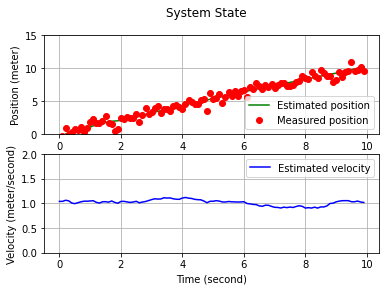

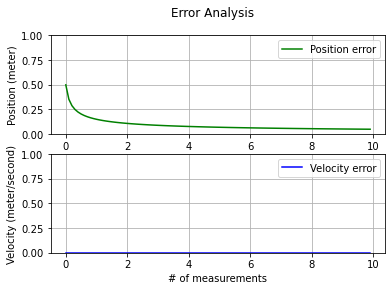

In [1]:
# Simple Kalman Filter (PV_model)
# Measurement:
# Distance [meter]
# Odometry [radian/second]

# Imports
from numpy import arange, array, eye, sqrt, zeros, random, diag
from numpy.random import normal
from numpy.linalg import inv, norm, cholesky
import matplotlib.pyplot as plt
from vanloan.vanloan import numeval


# System values
dt = 0.1       # interval [second]
samples = 100  # number of samples
r = 0.1**2.    # radius wheel (meter)
qv = 0.1**2    # process noise velocity [(meter/second)^2/second]
rp = 0.5**2    # measurement noise position [meter^2]
ro = 0.005**2  # measurement noise odometry [(radian/second)^2]


# Initial state vector
x0 = array([[0],    # position [meter]
            [1]])   # velocity [meter/second]
xt = x0; x = x0

# Initial covariance matrix
P0 = diag([10**2, 1**2])
P = P0

# Dynamic matrix
F = array([[0, 1],
           [0, 0]])

# White noise coefficients
G = array([[0],
           [sqrt(qv)]])

# Numerical evaluation (van Loan)
[phi, Q] = numeval(F, G, dt)

# Cholesky decomposition
C = cholesky(Q)

# Design matrix
H = array([[1, 0],
           [0, 1/r]])
#H = array([[1, 0]])

# Measurement covariance matrix
R = diag([rp, ro])
#R = array([[rp]])

# Initialize plot lists
x_all = []; P_all = []; z_all = []

# Main loop
for k in range(0, samples):
    
    # Process noise vector
    w = array([[0],
               [normal(0, 1)]])
    
    # Compute true trajectory
    xt = phi@xt + C@w
    
    # Measurement noise vector
    #v = array([[normal(0, sqrt(rp))],
    #           [normal(0, sqrt(ro))]])
           
    # Generate noisy measurements
    z = H@xt + normal(0, sqrt(rp))
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    # Kalman gain
    K = Pp@H.T@inv(H@Pp@H.T + R)
    
    # Measurement update
    x = xp + K@(z - H@xp)
    P = (eye(2) - K@H)@Pp
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    z_all.append(z)

# Extract plot vectors
pos = [x[0] for x in x_all]
vel = [x[1] for x in x_all]
pos_sd = [sqrt(P[0, 0]) for P in P_all]
vel_sd = [sqrt(P[1, 1]) for P in P_all]
meas = [z[0] for z in z_all]

# Time
time = arange(0, samples)*dt

# Plot results
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('System State')
ax1.plot(time, pos, 'g', label = 'Estimated position')
ax1.plot(time, meas, 'ro', label='Measured position')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 15)
ax1.legend(loc='lower right')
ax1.grid(True, which='both')
ax2.plot(time, vel, 'b', label = 'Estimated velocity')
ax2.set_xlabel('Time (second)')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 2)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error Analysis')
ax1.plot(time, pos_sd, 'g', label='Position error')
ax1.set_ylabel('Position (meter)')
ax1.set_ylim(0, 1)
ax1.legend(loc='best')
ax1.grid(True, which='both')
ax2.plot(time, vel_sd, 'b', label='Velocity error')
ax2.set_xlabel('# of measurements')
ax2.set_ylabel('Velocity (meter/second)')
ax2.set_ylim(0, 1)
ax2.legend(loc='best')
ax2.grid(True, which='both')
plt.show()

## Attitude and heading reference system (AHRS)
Many IMUs are equipped with a socalled attitude and heading reference system (AHRS) capability, meaning that the unit can provide attitude and heading information based on information from typically a gyroscope, accelerometer and magnetometer. Many of the limitations a gyroscope, accelerometer, and magnetometer face on their own can be mitigated by combining them together. However, there are still a few challenges that come with using a AHRS that can cause errors in the system's attitude estimate.

So, how can we utilize the common properties of these sensors in a AHRS solution?

An AHRS unit typically includes a 3-axis gyroscope, a 3-axis accelerometer, and a 3-axis magnetometer to determine an estimate of the orientation. Note that each of these sensors exhibit unique limitations and they contribute with different measurements in the combined system through what is called *sensor fusion*.